In [941]:
import pandas_gbq
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gmean

# User level analysis

Investigate:
- Avg Share of orders incentivised
- Avg Incentive value used per incentivised order 
- Avg Incentive Amount/Basket Value (AOV + Delivery + Service Fee) 


Exclude is_corporate and subscription (i.e. addons.subscriptions.subscription_id is null).

1 year time frame.

In [946]:
q_cust = '''
SELECT analytical_customer_id,global_entity_id, order_id,
  CASE WHEN (is_discount OR is_voucher OR is_joker)
    THEN 1 else 0 end as used_incentive,  
  CASE WHEN is_free_delivery
    THEN 1 else 0 end as has_free_delivery,  
  IFNULL(value.incentives.voucher_total_eur,0)+IFNULL(value.incentives.discount_total_eur, 0) AS incentive_value,
  value.order.total_order_value_eur as basket_value,
  CASE WHEN ad.subscription_id IS NULL THEN 0 ELSE 1 END AS is_subscription
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` left join unnest(addons.subscriptions) as ad
WHERE is_successful = true and global_entity_id="FO_NO" and date(partition_date_local) between "2023-01-01" and "2023-12-31" and is_corporate = false 
'''
q_cust_SG = '''
SELECT analytical_customer_id,global_entity_id, order_id,
  CASE WHEN (is_discount OR is_voucher OR is_joker)
    THEN 1 else 0 end as used_incentive,  
  CASE WHEN is_free_delivery
    THEN 1 else 0 end as has_free_delivery,  
  IFNULL(value.incentives.voucher_total_eur,0)+IFNULL(value.incentives.discount_total_eur, 0) AS incentive_value,
  value.order.total_order_value_eur as basket_value,
  CASE WHEN ad.subscription_id IS NULL THEN 0 ELSE 1 END AS is_subscription
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` left join unnest(addons.subscriptions) as ad
WHERE is_successful = true and global_entity_id="FP_SG" and date(partition_date_local) between "2023-01-01" and "2023-12-31" and is_corporate = false 
'''

In [947]:
df_customer = pandas_gbq.read_gbq(q_cust)


Downloading:  14%|█▍        |

Downloading:   0%|          |


Downloading:   2%|▏         |

Downloading:   2%|▏         |

Downloading:   5%|▍         |

Downloading:   5%|▍         |

Downloading:   7%|▋         |

Downloading:   7%|▋         |

Downloading:   9%|▉         |

Downloading:   9%|▉         |

Downloading:  12%|█▏        |

Downloading:  12%|█▏        |

Downloading:  14%|█▍        |

Downloading:  14%|█▍        |

Downloading:  17%|█▋        |

Downloading:  17%|█▋        |

Downloading:  19%|█▉        |

Downloading:  19%|█▉        |

Downloading:  21%|██▏       |

Downloading:  21%|██▏       |

Downloading:  24%|██▎       |

Downloading:  24%|██▎       |

Downloading:  26%|██▌       |

Downloading:  26%|██▌       |

Downloading:  28%|██▊       |

Downloading:  28%|██▊       |

Downloading:  31%|███       |

Downloading:  31%|███       |

Downloading:  33%|███▎      |

Downloading:  33%|███▎      |

Downloading:  35%|███▌      |

Downloading:  35%|███▌      |

Downlo

In [948]:
df_customer_SG = pandas_gbq.read_gbq(q_cust_SG)

Downloading: 100%|██████████|


In [949]:
df_customer['analytical_customer_id'].nunique()

755145

In [950]:
df_customer_SG['analytical_customer_id'].nunique()

1099582

In [951]:
df_customer=df_customer.merge(df_num_orders[df_num_orders['order_id']>=20]['analytical_customer_id'], on='analytical_customer_id')
df_customer_SG=df_customer_SG.merge(df_num_orders_SG[df_num_orders_SG['order_id']>=20]['analytical_customer_id'], on='analytical_customer_id')

## Avg share of orders incentivized
% of incentive and free delivery use distribution

In [952]:
df_incentivized = df_customer[(df_customer['incentive_value']<=df_customer['basket_value'])].groupby('analytical_customer_id')[['used_incentive', 'has_free_delivery']].mean().reset_index()
df_incentivized_nosubs = df_customer[(df_customer['incentive_value']<=df_customer['basket_value']) & (df_customer['is_subscription']==0)].groupby('analytical_customer_id')[['used_incentive', 'has_free_delivery']].mean().reset_index()
df_incentivized_SG = df_customer_SG[(df_customer_SG['incentive_value']<=df_customer_SG['basket_value'])].groupby('analytical_customer_id')[['used_incentive', 'has_free_delivery']].mean().reset_index()
df_incentivized_SG_nosubs = df_customer_SG[(df_customer_SG['incentive_value']<=df_customer_SG['basket_value']) & (df_customer_SG['is_subscription']==0)].groupby('analytical_customer_id')[['used_incentive', 'has_free_delivery']].mean().reset_index()

In [953]:
len(df_incentivized[df_incentivized['used_incentive']>0])/len(df_incentivized), len(df_incentivized_nosubs[df_incentivized_nosubs['used_incentive']>0])/len(df_incentivized_nosubs)

(0.9370361471514763, 0.9352155920437859)

In [857]:
len(df_incentivized_SG[df_incentivized_SG['used_incentive']>0])/len(df_incentivized_SG), len(df_incentivized_SG_nosubs[df_incentivized_SG_nosubs['used_incentive']>0])/len(df_incentivized_SG_nosubs)

0.9843735214558175

Text(0, 0.5, 'Number of users')

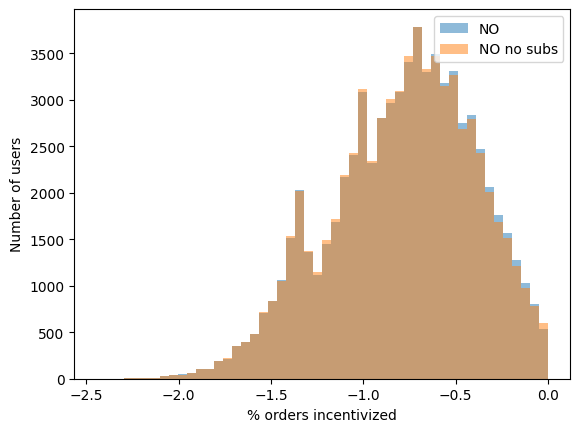

In [961]:
plt.hist(np.log10(df_incentivized[df_incentivized['used_incentive']!=0]['used_incentive']), label="NO", bins=50, alpha=0.5);
plt.hist(np.log10(df_incentivized_nosubs[df_incentivized_nosubs['used_incentive']!=0]['used_incentive']), label="NO no subs", bins=50, alpha=0.5);
plt.legend(loc='upper right');
plt.xlabel('% orders incentivized')
plt.ylabel('Number of users')

Text(0, 0.5, 'Number of users')

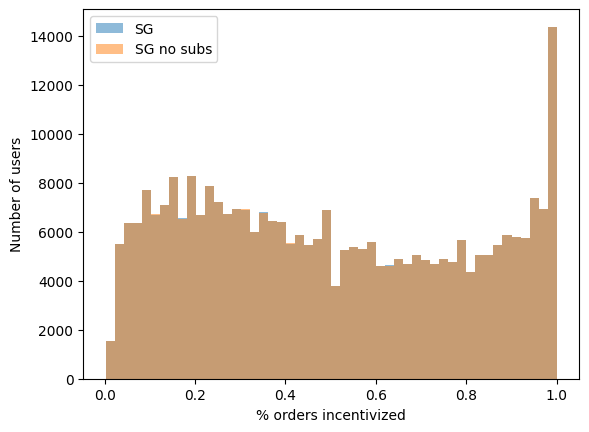

In [1057]:
plt.hist(df_incentivized_SG[df_incentivized_SG['used_incentive']!=0]['used_incentive'], label="SG", bins=50, alpha=0.5);
plt.hist(df_incentivized_SG_nosubs[df_incentivized_SG_nosubs['used_incentive']!=0]['used_incentive'], label="SG no subs", bins=50, alpha=0.5);

plt.legend(loc='upper left');
plt.xlabel('% orders incentivized')
plt.ylabel('Number of users')

In [957]:
len(df_incentivized[df_incentivized['has_free_delivery']>0])/len(df_incentivized),len(df_incentivized_nosubs[df_incentivized_nosubs['has_free_delivery']>0])/len(df_incentivized_nosubs)

(0.8643814405467457, 0.8563876651982378)

In [958]:
len(df_incentivized_SG[df_incentivized_SG['has_free_delivery']>0])/len(df_incentivized_SG), len(df_incentivized_SG_nosubs[df_incentivized_SG_nosubs['has_free_delivery']>0])/len(df_incentivized_SG_nosubs)

(0.6223855174799162, 0.6223594134422742)

Text(0, 0.5, 'Number of users')

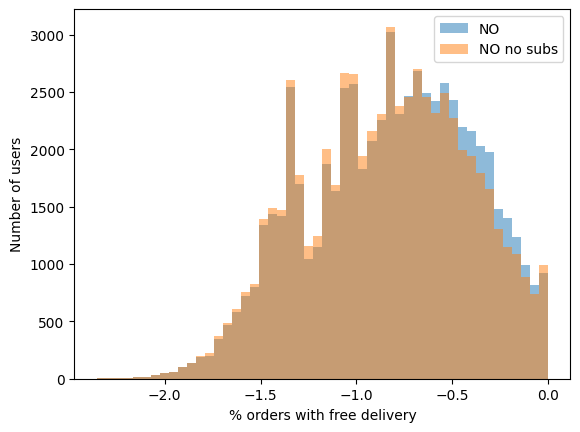

In [963]:
plt.hist(np.log10(df_incentivized[df_incentivized['has_free_delivery']>0]['has_free_delivery']), label="NO", bins=50, alpha=0.5);
plt.hist(np.log10(df_incentivized_nosubs[df_incentivized_nosubs['has_free_delivery']>0]['has_free_delivery']), label="NO no subs", bins=50, alpha=0.5);
plt.legend(loc='upper right');
plt.xlabel('% orders with free delivery')
plt.ylabel('Number of users')

Text(0, 0.5, 'Number of users')

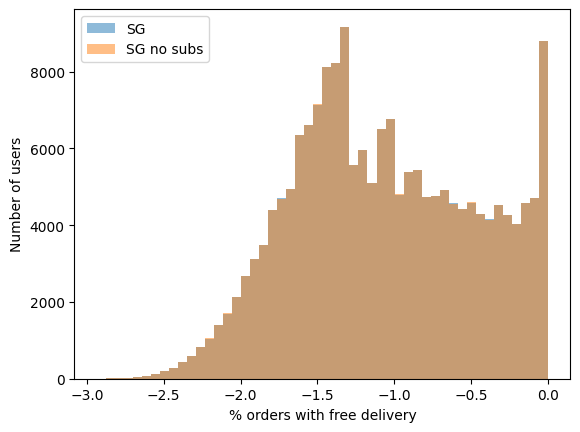

In [1056]:
plt.hist(np.log10(df_incentivized_SG[df_incentivized_SG['has_free_delivery']>0]['has_free_delivery']), label="SG", bins=50, alpha=0.5);
plt.hist(np.log10(df_incentivized_SG_nosubs[df_incentivized_SG_nosubs['has_free_delivery']>0]['has_free_delivery']), label="SG no subs", bins=50, alpha=0.5);
plt.legend(loc='upper left');
plt.xlabel('% orders with free delivery')
plt.ylabel('Number of users')

## Avg incentive value per incentivized order

In [969]:
df_avg_order = df_customer[(df_customer['used_incentive']==1) & (df_customer['incentive_value']<=df_customer['basket_value'])].groupby('analytical_customer_id')\
.agg(mean_incentive_value=('incentive_value', 'mean'), basket_value=('basket_value', 'mean') ,used_incentive=('used_incentive', 'sum'), total_incentive_value=('incentive_value', 'sum')).reset_index()
df_avg_order_nosubs = df_customer[(df_customer['used_incentive']==1) & (df_customer['is_subscription']==0) & (df_customer['incentive_value']<=df_customer['basket_value'])].groupby('analytical_customer_id')\
.agg(mean_incentive_value=('incentive_value', 'mean'), basket_value=('basket_value', 'mean') ,used_incentive=('used_incentive', 'sum'), total_incentive_value=('incentive_value', 'sum')).reset_index()

df_avg_order_SG = df_customer_SG[(df_customer_SG['used_incentive']==1) & (df_customer['incentive_value']<=df_customer['basket_value'])].groupby('analytical_customer_id')\
.agg(mean_incentive_value=('incentive_value', 'mean'), basket_value=('basket_value', 'mean') ,used_incentive=('used_incentive', 'sum'), total_incentive_value=('incentive_value', 'sum')).reset_index()
df_avg_order_SG_nosubs = df_customer_SG[(df_customer_SG['used_incentive']==1) & (df_customer_SG['is_subscription']==0) & (df_customer['incentive_value']<=df_customer['basket_value'])].groupby('analytical_customer_id')\
.agg(mean_incentive_value=('incentive_value', 'mean'), basket_value=('basket_value', 'mean') ,used_incentive=('used_incentive', 'sum'), total_incentive_value=('incentive_value', 'sum')).reset_index()

Distribution of incentive values:

Text(0, 0.5, 'Number of users')

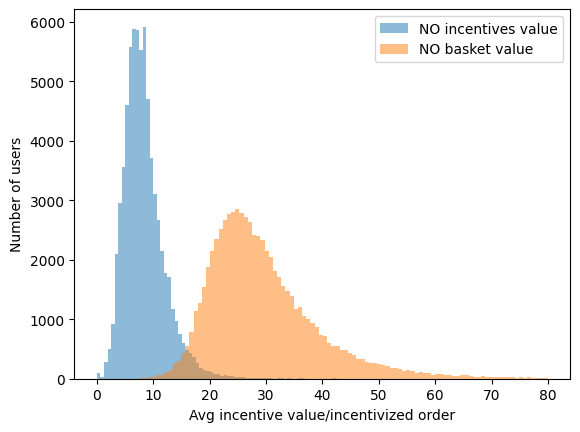

In [865]:
plt.hist(df_avg_order[(df_avg_order['mean_incentive_value']<100) & (df_avg_order['basket_value']<80) & (df_avg_order['used_incentive']<80)]['mean_incentive_value'], bins=100, label="NO incentives value", alpha=0.5);
plt.hist(df_avg_order[(df_avg_order['mean_incentive_value']<100) & (df_avg_order['basket_value']<80) & (df_avg_order['used_incentive']<80)]['basket_value'], bins=100, label="NO basket value", alpha=0.5);
#plt.hist(df_avg_order[(df_avg_order['incentive_value']<100) & (df_avg_order['basket_value']<80) & (df_avg_order['used_incentive']<80)]['used_incentive'], bins=100, label="NO incentivized orders distribution", alpha=0.5);
#plt.hist(df_avg_order[(df_avg_order['incentive_value']<100) & (df_avg_order['basket_value']<80) & (df_avg_order['used_incentive']<80)]['total_incentive_value'], bins=100, label="NO total_incentive_value", alpha=0.5);
plt.legend(loc='upper right');
plt.xlabel('Avg incentive value/incentivized order')
plt.ylabel('Number of users')

Text(0, 0.5, 'Number of users')

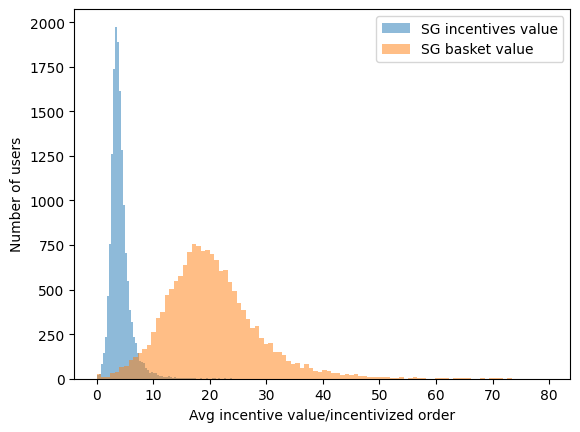

In [967]:
plt.hist(df_avg_order_SG[(df_avg_order_SG['mean_incentive_value']<100) & (df_avg_order_SG['basket_value']<80) & (df_avg_order_SG['used_incentive']<80)]['mean_incentive_value'], bins=100, label="SG incentives value", alpha=0.5);
plt.hist(df_avg_order_SG[(df_avg_order_SG['mean_incentive_value']<100) & (df_avg_order_SG['basket_value']<80) & (df_avg_order_SG['used_incentive']<80)]['basket_value'], bins=100, label="SG basket value", alpha=0.5);plt.legend(loc='upper right');
plt.xlabel('Avg incentive value/incentivized order')
plt.ylabel('Number of users')

## Avg incentive value / basket

In [971]:
df_avg_basket = df_customer.groupby('analytical_customer_id')[['incentive_value', 'basket_value']].sum().reset_index()
df_avg_basket_nosubs = df_customer[df_customer['is_subscription']==0].groupby('analytical_customer_id')[['incentive_value', 'basket_value']].sum().reset_index()

df_avg_basket_SG = df_customer_SG.groupby('analytical_customer_id')[['incentive_value', 'basket_value']].sum().reset_index()
df_avg_basket_SG_nosubs = df_customer_SG[df_customer_SG['is_subscription']==0].groupby('analytical_customer_id')[['incentive_value', 'basket_value']].sum().reset_index()

In [972]:
def divide_cols(row):
    try:
        res = float(row['incentive_value'])/float(row['basket_value'])
    except ZeroDivisionError:
        res = np.nan
    return res

In [973]:
df_avg_basket['incentive_basket_value'] = df_avg_basket.apply(lambda x: divide_cols(x), axis = 1)
df_avg_basket_nosubs['incentive_basket_value'] = df_avg_basket.apply(lambda x: divide_cols(x), axis = 1)
df_avg_basket_SG['incentive_basket_value'] = df_avg_basket_SG.apply(lambda x: divide_cols(x), axis = 1)
df_avg_basket_SG_nosubs['incentive_basket_value'] = df_avg_basket_SG.apply(lambda x: divide_cols(x), axis = 1)

In [974]:
df_avg_basket = df_avg_basket.dropna()
df_avg_basket_SG = df_avg_basket_SG.dropna()

Text(0, 0.5, 'Number of users')

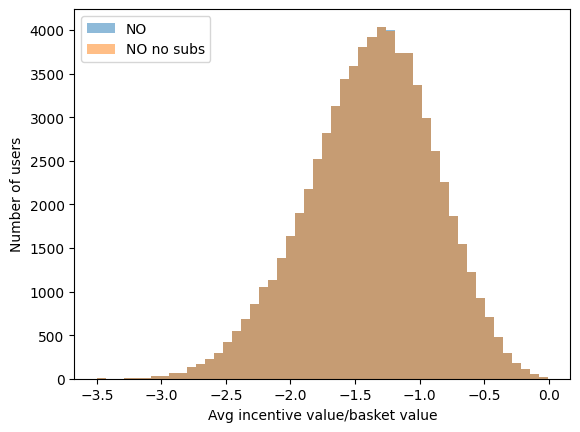

In [1055]:
plt.hist(np.log10(df_avg_basket[(df_avg_basket['incentive_basket_value']<1) & (df_avg_basket['incentive_basket_value']>0)]['incentive_basket_value'].astype(float)), bins=50, label="NO", alpha=0.5);
plt.hist(np.log10(df_avg_basket_nosubs[(df_avg_basket_nosubs['incentive_basket_value']<1) & (df_avg_basket_nosubs['incentive_basket_value']>0)]['incentive_basket_value'].astype(float)), bins=50, label="NO no subs", alpha=0.5);
plt.legend(loc='upper left');
plt.xlabel('Avg incentive value/basket value')
plt.ylabel('Number of users')

Text(0, 0.5, 'Number of users')

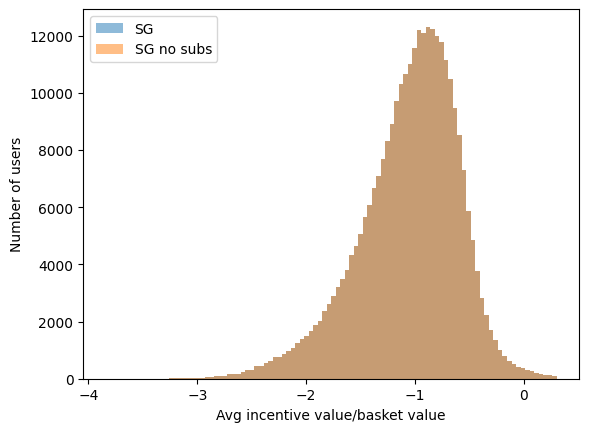

In [1054]:
plt.hist(np.log10(df_avg_basket_SG[(df_avg_basket_SG['incentive_basket_value']<2)  & (df_avg_basket_SG['incentive_basket_value']>0)]['incentive_basket_value'].astype(float)), bins=100, label="SG", alpha=0.5);
plt.hist(np.log10(df_avg_basket_SG_nosubs[(df_avg_basket_SG_nosubs['incentive_basket_value']<2)  & (df_avg_basket_SG_nosubs['incentive_basket_value']>0)]['incentive_basket_value'].astype(float)), bins=100, label="SG no subs", alpha=0.5);
plt.legend(loc='upper left');
plt.xlabel('Avg incentive value/basket value')
plt.ylabel('Number of users')

In [980]:
df_sol_ = df_incentivized.merge(df_avg_basket[['analytical_customer_id', 'incentive_basket_value']], on='analytical_customer_id')
df_sol = df_sol_.merge(df_avg_order[['analytical_customer_id', 'mean_incentive_value']], on='analytical_customer_id')

df_solSG_ = df_incentivized_SG.merge(df_avg_basket_SG[['analytical_customer_id', 'incentive_basket_value']], on='analytical_customer_id')
df_sol_SG = df_solSG_.merge(df_avg_order_SG[['analytical_customer_id', 'mean_incentive_value']], on='analytical_customer_id')

In [981]:
df_solnosubs_ = df_incentivized_nosubs.merge(df_avg_basket_nosubs[['analytical_customer_id', 'incentive_basket_value']], on='analytical_customer_id')
df_sol_nosubs = df_solnosubs_.merge(df_avg_order_nosubs[['analytical_customer_id', 'mean_incentive_value']], on='analytical_customer_id')

df_solSG_nosubs_ = df_incentivized_SG_nosubs.merge(df_avg_basket_SG_nosubs[['analytical_customer_id', 'incentive_basket_value']], on='analytical_customer_id')
df_sol_SG_nosubs = df_solSG_nosubs_.merge(df_avg_order_SG_nosubs[['analytical_customer_id', 'mean_incentive_value']], on='analytical_customer_id')

## Normalize columns

In [982]:
for col in ['used_incentive', 'has_free_delivery', 'incentive_basket_value', 'mean_incentive_value']:
    df_sol[col+'_normalized'] = np.where(df_sol[col] != 0, np.log10(df_sol[col]), 0)
    df_sol_nosubs[col+'_normalized'] = np.where(df_sol_nosubs[col] != 0, np.log10(df_sol_nosubs[col]), 0)
    df_sol_SG[col+'_normalized'] = np.where(df_sol_SG[col] != 0, np.log10(df_sol_SG[col]), 0)    
    df_sol_SG_nosubs[col+'_normalized'] = np.where(df_sol_SG_nosubs[col] != 0, np.log10(df_sol_SG_nosubs[col]), 0)

/Users/a.capuano/opt/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/core/arrays/masked.py:559: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Users/a.capuano/opt/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/core/arrays/masked.py:559: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Users/a.capuano/opt/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/core/arrays/masked.py:559: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Users/a.capuano/opt/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/core/arrays/masked.py:559: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Users/a.capuano/opt/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/core/arrays/masked.py:559: RuntimeWarning: divide by zero encountered in log10
  result 

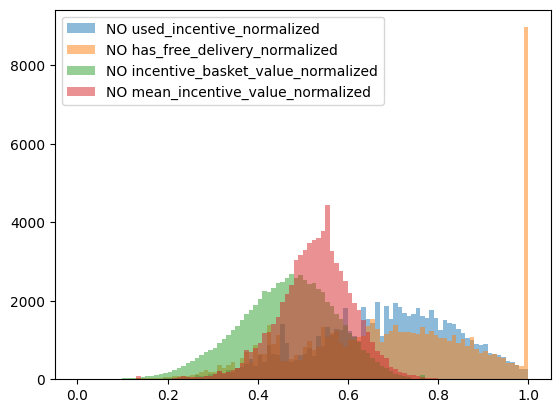

In [1051]:
plt.hist(df_sol['used_incentive_normalized'], bins=100, label="NO used_incentive_normalized", alpha=0.5);
plt.hist(df_sol['has_free_delivery_normalized'], bins=100, label="NO has_free_delivery_normalized", alpha=0.5);
plt.hist(df_sol['incentive_basket_value_normalized'], bins=100, label="NO incentive_basket_value_normalized", alpha=0.5);
plt.hist(df_sol['mean_incentive_value_normalized'], bins=100, label="NO mean_incentive_value_normalized", alpha=0.5);
plt.legend(loc='upper left');

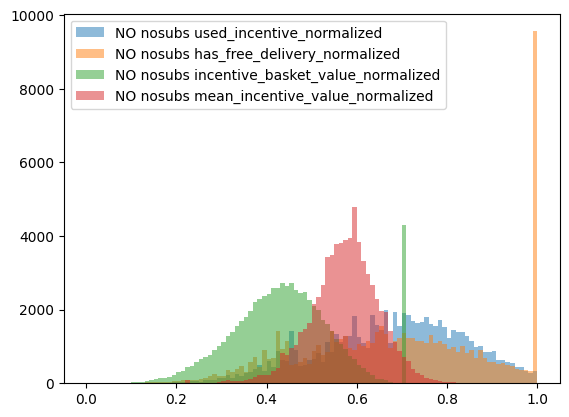

In [1052]:
plt.hist(df_sol_nosubs['used_incentive_normalized'], bins=100, label="NO nosubs used_incentive_normalized", alpha=0.5);
plt.hist(df_sol_nosubs['has_free_delivery_normalized'], bins=100, label="NO nosubs has_free_delivery_normalized", alpha=0.5);
plt.hist(df_sol_nosubs['incentive_basket_value_normalized'], bins=100, label="NO nosubs incentive_basket_value_normalized", alpha=0.5);
plt.hist(df_sol_nosubs['mean_incentive_value_normalized'], bins=100, label="NO nosubs mean_incentive_value_normalized", alpha=0.5);
plt.legend(loc='upper left');

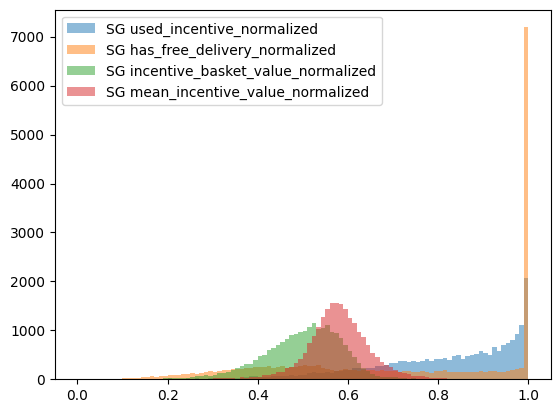

In [1050]:
plt.hist(df_sol_SG['used_incentive_normalized'], bins=100, label="SG used_incentive_normalized", alpha=0.5);
plt.hist(df_sol_SG['has_free_delivery_normalized'], bins=100, label="SG has_free_delivery_normalized", alpha=0.5);
plt.hist(df_sol_SG['incentive_basket_value_normalized'], bins=100, label="SG incentive_basket_value_normalized", alpha=0.5);
plt.hist(df_sol_SG['mean_incentive_value_normalized'], bins=100, label="SG mean_incentive_value_normalized", alpha=0.5);
plt.legend(loc='upper left');


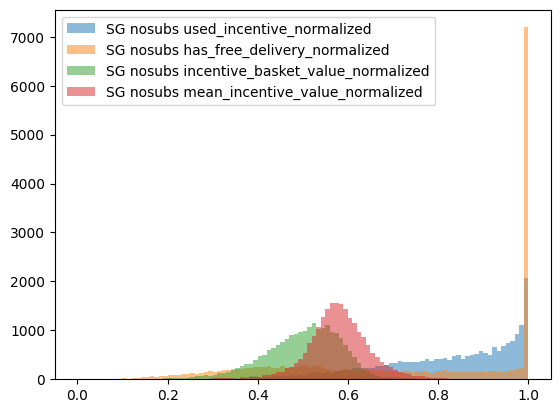

In [1049]:
plt.hist(df_sol_SG_nosubs['used_incentive_normalized'], bins=100, label="SG nosubs used_incentive_normalized", alpha=0.5);
plt.hist(df_sol_SG_nosubs['has_free_delivery_normalized'], bins=100, label="SG nosubs has_free_delivery_normalized", alpha=0.5);
plt.hist(df_sol_SG_nosubs['incentive_basket_value_normalized'], bins=100, label="SG nosubs incentive_basket_value_normalized", alpha=0.5);
plt.hist(df_sol_SG_nosubs['mean_incentive_value_normalized'], bins=100, label="SG nosubs mean_incentive_value_normalized", alpha=0.5);
plt.legend(loc='upper left');


In [1033]:
scaler = MinMaxScaler()
columns_to_scale = [col for col in df_sol.columns if 'normalized' in col]


df_sol_SG[columns_to_scale] = scaler.fit_transform(df_sol_SG[columns_to_scale])
df_sol_SG_nosubs[columns_to_scale] = scaler.fit_transform(df_sol_SG_nosubs[columns_to_scale])
df_sol[columns_to_scale] = scaler.fit_transform(df_sol[columns_to_scale])
df_sol_nosubs[columns_to_scale] = scaler.fit_transform(df_sol_nosubs[columns_to_scale])

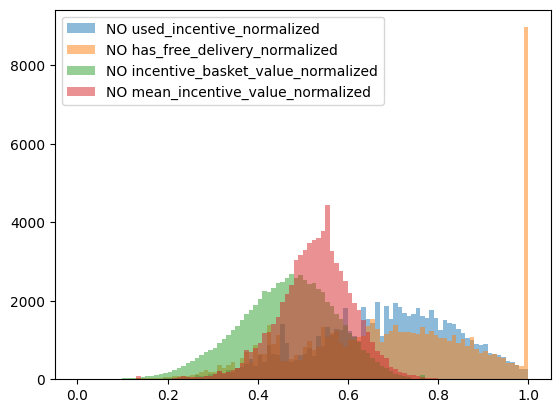

In [1048]:
plt.hist(df_sol['used_incentive_normalized'], bins=100, label="NO used_incentive_normalized", alpha=0.5);
plt.hist(df_sol['has_free_delivery_normalized'], bins=100, label="NO has_free_delivery_normalized", alpha=0.5);
plt.hist(df_sol['incentive_basket_value_normalized'], bins=100, label="NO incentive_basket_value_normalized", alpha=0.5);
plt.hist(df_sol['mean_incentive_value_normalized'], bins=100, label="NO mean_incentive_value_normalized", alpha=0.5);
plt.legend(loc='upper left');


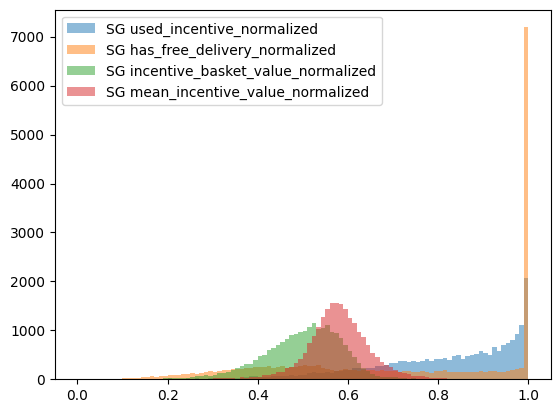

In [1047]:
plt.hist(df_sol_SG['used_incentive_normalized'], bins=100, label="SG used_incentive_normalized", alpha=0.5);
plt.hist(df_sol_SG['has_free_delivery_normalized'], bins=100, label="SG has_free_delivery_normalized", alpha=0.5);
plt.hist(df_sol_SG['incentive_basket_value_normalized'], bins=100, label="SG incentive_basket_value_normalized", alpha=0.5);
plt.hist(df_sol_SG['mean_incentive_value_normalized'], bins=100, label="SG mean_incentive_value_normalized", alpha=0.5);
plt.legend(loc='upper left');


Relationship between avg incentive value/incentivized order and avg incentive value per basket size:

In [1043]:
#plt.scatter(df_sol['mean_incentive_value_normalized'], df_sol['incentive_basket_value_normalized']);
#plt.xlabel('Avg incentive value/incentivized order')
#plt.ylabel('Avg incentive value/basket')

In [1044]:
#plt.scatter(df_sol_SG['mean_incentive_value_normalized'], df_sol_SG['incentive_basket_value_normalized']);
#plt.xlabel('Avg incentive value/incentivized order')
#plt.ylabel('Avg incentive value/basket')

## Score calculation

In [987]:
def calculate_score(row):
    return (row['used_incentive_normalized']+row['has_free_delivery_normalized']+\
            row['incentive_basket_value_normalized']+row['mean_incentive_value_normalized'])/4,\
            gmean([row['used_incentive_normalized'],row['has_free_delivery_normalized'],\
            row['incentive_basket_value_normalized'],row['mean_incentive_value_normalized']])

In [988]:
df_sol['mean_score'] = df_sol.apply(lambda x: calculate_score(x)[0], axis=1)
df_sol['g_mean_score'] = df_sol.apply(lambda x: calculate_score(x)[1], axis=1)
df_sol_SG['mean_score'] = df_sol_SG.apply(lambda x: calculate_score(x)[0], axis=1)
df_sol_SG['g_mean_score']= df_sol_SG.apply(lambda x: calculate_score(x)[1], axis=1)

df_sol_nosubs['mean_score'] = df_sol_nosubs.apply(lambda x: calculate_score(x)[0], axis=1)
df_sol_nosubs['g_mean_score'] = df_sol_nosubs.apply(lambda x: calculate_score(x)[1], axis=1)
df_sol_SG_nosubs['mean_score'] = df_sol_SG_nosubs.apply(lambda x: calculate_score(x)[0], axis=1)
df_sol_SG_nosubs['g_mean_score']= df_sol_SG_nosubs.apply(lambda x: calculate_score(x)[1], axis=1)

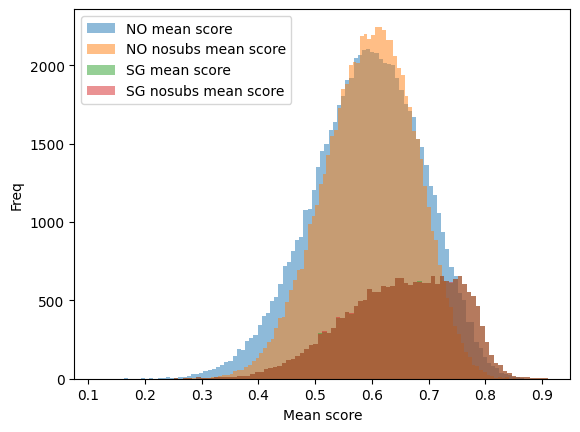

In [1046]:
plt.hist(df_sol['mean_score'], bins=100, label="NO mean score", alpha=0.5);
plt.hist(df_sol_nosubs['mean_score'], bins=100, label="NO nosubs mean score", alpha=0.5);
plt.hist(df_sol_SG['mean_score'], bins=100, label="SG mean score", alpha=0.5);
plt.hist(df_sol_SG_nosubs['mean_score'], bins=100, label="SG nosubs mean score", alpha=0.5);
plt.xlabel('Mean score')
plt.ylabel('Freq')
plt.legend(loc='upper left');


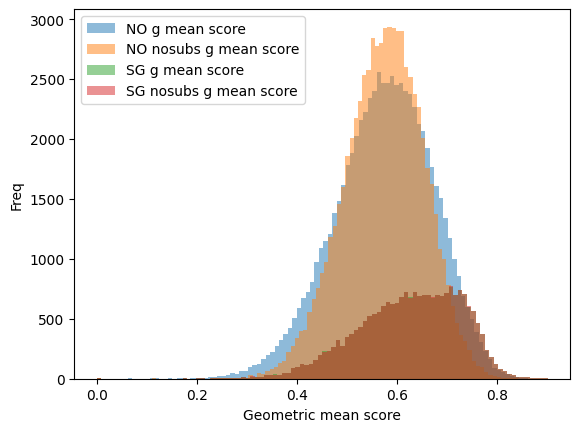

In [1045]:
plt.hist(df_sol['g_mean_score'], bins=100, label="NO g mean score", alpha=0.5);
plt.hist(df_sol_nosubs['g_mean_score'], bins=100, label="NO nosubs g mean score", alpha=0.5);
plt.hist(df_sol_SG['g_mean_score'], bins=100, label="SG g mean score", alpha=0.5);
plt.hist(df_sol_SG_nosubs['g_mean_score'], bins=100, label="SG nosubs g mean score", alpha=0.5);
plt.xlabel('Geometric mean score')
plt.ylabel('Freq')
plt.legend(loc='upper left');


In [991]:
df_sol.to_csv('NO_2023_incentive_score.csv')
df_sol_nosubs.to_csv('NO_2023_incentive_score_nosubs.csv')

In [992]:
df_sol_SG.to_csv('SG_2023_incentive_score.csv')
df_sol_SG_nosubs.to_csv('SG_2023_incentive_score_nosubs.csv')

# Check features distribution for low, medium and high score
- Low medium and high are based on mean+std dev value of the distribution

In [1032]:
mean_val = df_sol['mean_score'].mean()
stdev_val = df_sol['mean_score'].std()
mean_val, stdev_val

(0.591872580847276, 0.09612528738040867)

In [1031]:
df_high = df_sol[df_sol['mean_score']>=(mean_val+stdev_val)]
df_mid = df_sol[(df_sol['mean_score']>(mean_val-stdev_val)) & (df_sol['mean_score']<=(mean_val+stdev_val))]
df_low = df_sol[df_sol['mean_score']<=(mean_val-stdev_val)]

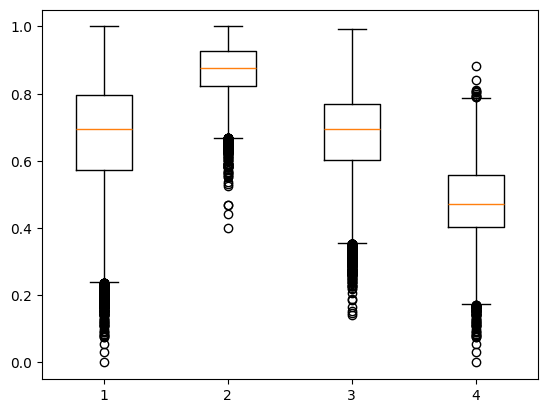

In [1027]:
plt.boxplot ([df_sol['used_incentive_normalized'], df_high['used_incentive_normalized'], df_mid['used_incentive_normalized'], df_low['used_incentive_normalized']]);


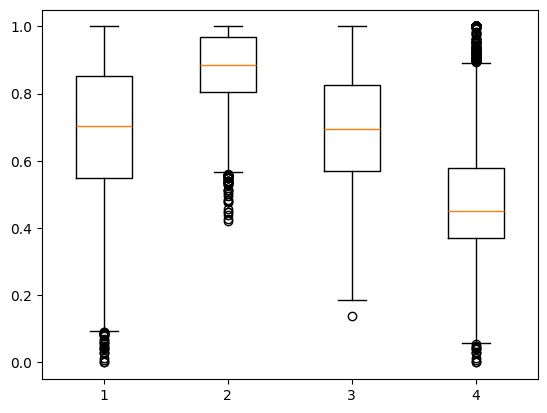

In [1028]:
plt.boxplot ([df_sol['has_free_delivery_normalized'], df_high['has_free_delivery_normalized'], df_mid['has_free_delivery_normalized'], df_low['has_free_delivery_normalized']]);


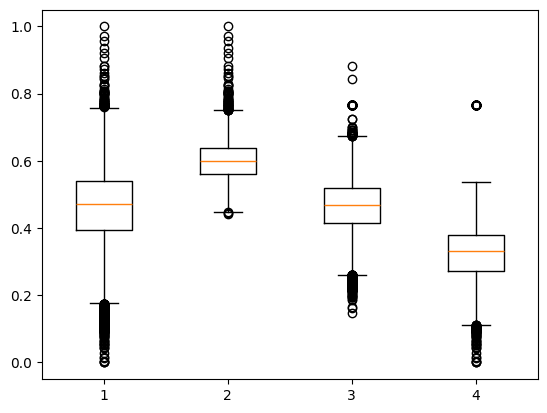

In [1029]:
plt.boxplot ([df_sol['incentive_basket_value_normalized'], df_high['incentive_basket_value_normalized'], df_mid['incentive_basket_value_normalized'], df_low['incentive_basket_value_normalized']]);


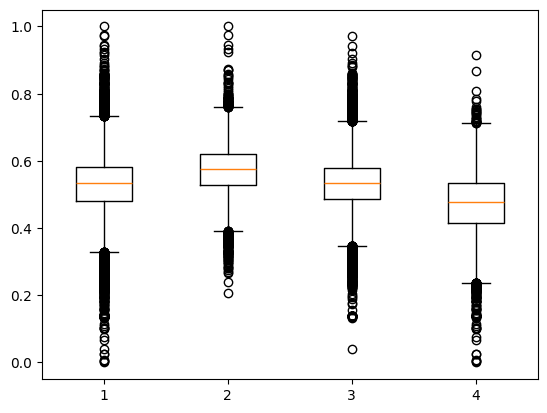

In [1030]:
plt.boxplot ([df_sol['mean_incentive_value_normalized'], df_high['mean_incentive_value_normalized'], df_mid['mean_incentive_value_normalized'], df_low['mean_incentive_value_normalized']]);


In [1038]:
mean_val_SG = df_sol_SG['mean_score'].mean()
stdev_val_SG = df_sol_SG['mean_score'].std()
print(mean_val_SG, stdev_val_SG)
df_high_SG = df_sol_SG[df_sol_SG['mean_score']>=(mean_val_SG+stdev_val_SG)]
df_mid_SG = df_sol_SG[(df_sol_SG['mean_score']>(mean_val_SG-stdev_val_SG)) & (df_sol_SG['mean_score']<=(mean_val_SG+stdev_val_SG))]
df_low_SG = df_sol_SG[df_sol_SG['mean_score']<=(mean_val_SG-stdev_val_SG)]

0.650922255777506 0.09900894549084639


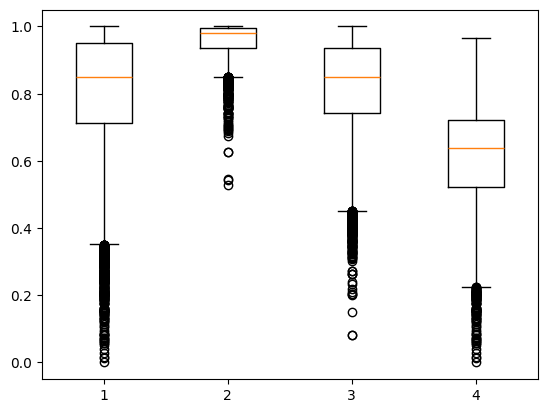

In [1039]:
plt.boxplot ([df_sol_SG['used_incentive_normalized'], df_high_SG['used_incentive_normalized'], df_mid_SG['used_incentive_normalized'], df_low_SG['used_incentive_normalized']]);


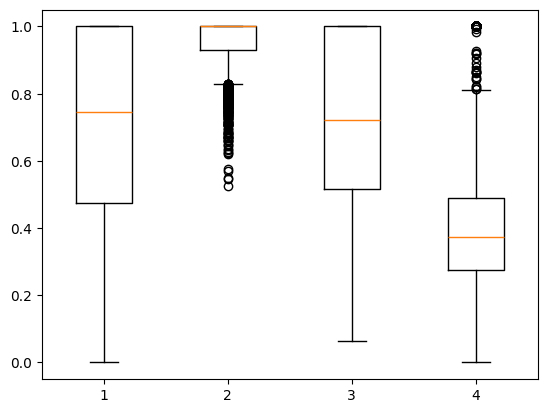

In [1040]:
plt.boxplot ([df_sol_SG['has_free_delivery_normalized'], df_high_SG['has_free_delivery_normalized'], df_mid_SG['has_free_delivery_normalized'], df_low_SG['has_free_delivery_normalized']]);


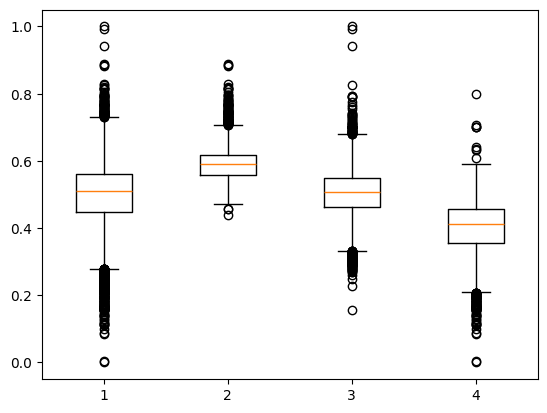

In [1041]:
plt.boxplot ([df_sol_SG['incentive_basket_value_normalized'], df_high_SG['incentive_basket_value_normalized'], df_mid_SG['incentive_basket_value_normalized'], df_low_SG['incentive_basket_value_normalized']]);


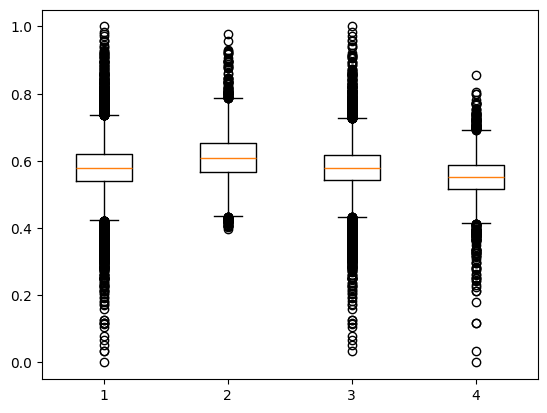

In [1042]:
plt.boxplot ([df_sol_SG['mean_incentive_value_normalized'], df_high_SG['mean_incentive_value_normalized'], df_mid_SG['mean_incentive_value_normalized'], df_low_SG['mean_incentive_value_normalized']]);


- mean_incentive_value_normalized: it spans less values than the other features?

# Order level analysis

In [20]:
q='''
SELECT 
IFNULL(value.incentives.voucher_total_eur,0) as is_voucher_incentive_value, 
IFNULL(value.incentives.discount_dh_eur,0)+IFNULL(value.incentives.discount_other_eur,0) is_discount_incentive_value,
IFNULL(value.incentives.joker_customer_discount_eur,0) is_joker_incentive_value,
IFNULL(value.incentives.voucher_total_eur,0)+IFNULL(value.incentives.discount_dh_eur,0)+IFNULL(value.incentives.discount_other_eur,0)
+IFNULL(value.incentives.joker_customer_discount_eur,0) as total_incentive_value,
value.order.gmv_eur as basket_value, 
is_discount, 
is_voucher, 
is_joker,
is_free_delivery 
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` 
WHERE is_successful = true and global_entity_id="FO_NO" and date(partition_date_local) = "2023-12-12"
'''

In [21]:
df = pandas_gbq.read_gbq(q)

Downloading: 100%|██████████|


In [22]:
df[df['is_joker']==True]
#print(len(df[df['is_discount']==True]))

,is_voucher_incentive_value,is_discount_incentive_value,is_joker_incentive_value,total_incentive_value,basket_value,is_discount,is_voucher,is_joker,is_free_delivery
23,0E-9,0E-9,3.800000000,3.800000000,13.010000000,True,False,True,True
57,0E-9,0E-9,3.800000000,3.800000000,13.690000000,True,False,True,True
74,0E-9,0E-9,3.800000000,3.800000000,13.770000000,True,False,True,True
93,0E-9,0E-9,8.450000000,8.450000000,28.560000000,True,False,True,True
152,0E-9,0E-9,3.800000000,3.800000000,14.280000000,True,False,True,True
...,...,...,...,...,...,...,...,...,...
14707,0E-9,0E-9,8.450000000,8.450000000,62.520000000,True,False,True,False
14719,0E-9,0E-9,8.450000000,8.450000000,58.630000000,True,False,True,False
14783,0E-9,0E-9,8.450000000,8.450000000,47.820000000,True,False,True,False
14819,0E-9,0E-9,8.450000000,8.450000000,52.470000000,True,False,True,False


In [23]:
def plot_hist(df, subset):
    df_sub = df[df[subset]==True]
    print("Share: %", round(len(df_sub)*100/len(df), 2))
    fig, ax = plt.subplots(figsize = (4,4))
    ax.hist(df_sub['total_incentive_value'], alpha=0.5, label='total_incentive_value')
    if subset!="is_free_delivery":
        ax.hist(df_sub[subset+'_incentive_value'], alpha=0.5, label='basket_value_incentive_specific')
    ax.hist(df_sub['basket_value'], alpha=0.5, label='basket_value')
    ax.legend(loc='upper right')
    plt.show()

def plot_all(df):
    for col in df.columns:
        if "value" not in col and "is_" in col and 'incentive_value' not in col:
            print(col)
            plot_hist(df, col)

is_discount
Share: % 22.97


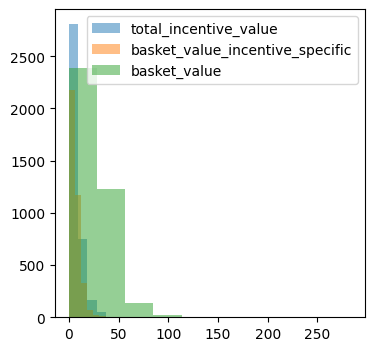

is_voucher
Share: % 10.5


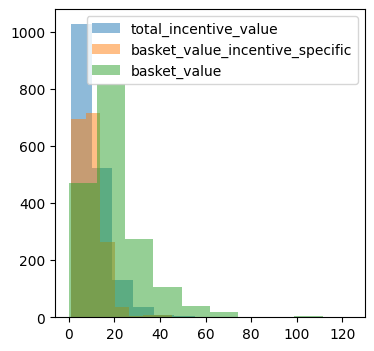

is_joker
Share: % 3.4


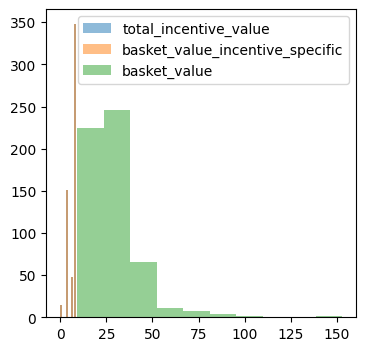

is_free_delivery
Share: % 28.78


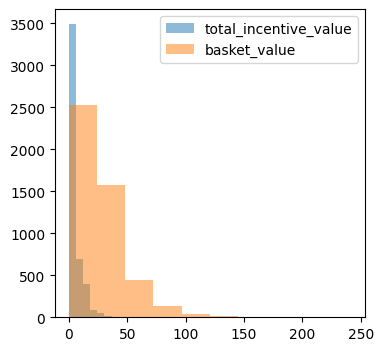

In [24]:
plot_all(df) #EUR

In [ ]:
df.columns

### Columns description:
#### Incentives
- **is_discount**: True if some other discount was given (**and used?**) to the customer (other than voucher and joker), e.g. Meal deal / Happy hour / Free drink / Pizza Montag / Free Delivery etc.	
- **is_voucher**: True if a voucher code was used, when the customer types in a code during the order process to receive a price reduction.	
- **is_free_delivery**: True if there was no delivery fee for the order.
- **is_joker**: True if the joker feature was used in the order process.
- **gmv_eur**: Gross Merchandise Value (GMV) is a metric that measures your total value of sales over a certain period of time. In this case we are calculating for each order the total amount Paid compulsory by Customer (also called MPR after DH Subsidy). Note that for top-level reporting this is calculated on Successful Orders, but not necessarily on Commissionable Orders. Includes VAT, all fees and incentives. Excludes Rider tip. Amount the customer paid (after vouchers and discounts, including delivery fee, allowance amount and **excluding tips**) in Euro.

For the discounts:
- **is_voucher_incentive_value**: we take the value.incentives.voucher_total_eur value which includes both DH vouchers and non
- **is_discount_incentive_value**: we sum discount_dh_eur and discount_other_eur because discount_total_eur also contains joker - also summing all the appropriate columns the result wil still differ from the "total" column due to rounding errors
- **is_joker_incentive_value**: the value is not null only if the joker feature was used in the order process (joker is a customized incentive, time limited)
- delivery free has no incentive value

Potentially interesting columns:
is_acquisition, is_corporate, is_qcommerce, value.incentives.wallet_total_eur

A way to differentiate dh vs vendor voucher value is to look at the respective voucher amount (the column contains a voucher amount breakdown).

To calculate the incentive value:
vouchers.amount_eur field is similar to value.incentives.voucher_total_eur (field I actually used), but in amount_eur the voucher value is divided against each voucher code/ campaign name.

Commission data info comes a month later, however January did not seem to have data for the day - but we are not interested in commission data.